In [1]:
import pickle
import os
from itertools import chain

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
STORAGE = 'results/230401'

# Line charts

In [2]:
def get_df(first, first_label, second, second_label):
    c =['series', 'x', 'y']
    df_ = pd.DataFrame(columns=c)
    df_.loc[0,:] = ['Genetic optimisation', 0, first[0]]
    df_ = df_.append(pd.DataFrame.from_records(
        [[first_label, i, x] for i, x in enumerate(first)], columns=c), ignore_index=True)
    df_ = df_.append(pd.DataFrame.from_records(
        [[second_label, i+len(first)+1, x] for i, x in enumerate(second)], columns=c), ignore_index=True)
    return df_

def get_plot_form_data(d):
    h_res = [x for x, _ in d['res-ord']['res'][0]]
    h_ord = [x for x, _ in d['res-ord']['ord'][0]]
    h_res2 = [x for x, _ in d['ord-res']['res'][0]]
    h_ord2 = [x for x, _ in d['ord-res']['ord'][0]]
    # df = get_df(ord, 'Activity order', res, 'Resource allocation')
    dpi = 150
    fig, ax = plt.subplots(figsize=(1024 / 3 * 2 / dpi, 768 / dpi), dpi=dpi)
    # fig, ax = plt.subplots(figsize=(1024 / dpi, 768 / dpi), dpi=dpi)
    ax.plot(np.arange(len(h_res)), h_res, '-', color='#6C8EBF', linewidth=3, label='Resource optimization')
    ax.plot(np.arange(len(h_res) - 1, len(h_res) + len(h_ord) - 1), h_ord, '-', color='#82B366', linewidth=3, label='Order optimization')
    ax.plot(np.arange(len(h_ord2)), h_ord2, '--', color='#82B366', linewidth=3,)# label='Order-first')
    ax.plot(np.arange(len(h_ord2) - 1, len(h_ord2) + len(h_res2) - 1), h_res2, '--', color='#6C8EBF', linewidth=3,)
            # label='Resource-second')
    ax.plot([0], [h_res[0]], 'ro', label='Initial approximation')
    # ax.legend()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Schedule cost')
    match d['wg_name']:
        case 'large':
            wg_name = 'большой'
        case 'medium':
            wg_name = 'средний'
        case _:
            wg_name = 'малый'

    fig.suptitle(f'{d["wg_name"].capitalize()} graph (works count - {d["works"]})')
    plt.tight_layout()
    return fig, ax

def unpickle(f):
    with open(f, 'rb') as pkl:
        return pickle.load(pkl)

def get_plot_from_file(f):
    return get_plot_form_data(unpickle(f))

def get_f_names(folder, prefix = '', postfix = '.pickle'):
    return [f for f in list(os.walk(folder))[0][-1] if f.startswith(prefix) and f.endswith(postfix)]

In [12]:
both_files = get_f_names(STORAGE)

In [8]:
both_files

['both-small.pickle', 'both-large.pickle', 'both-medium.pickle']

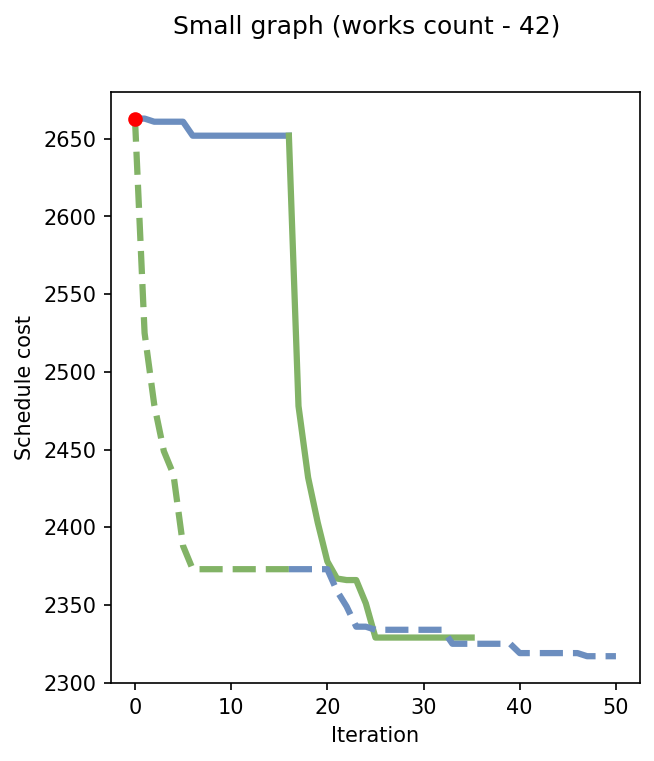

In [9]:
fig, ax = get_plot_from_file(f'{STORAGE}/{both_files[0]}')
with plt.style.context('seaborn-v0_8-notebook'):
    fig.savefig(f'{STORAGE}/white-stylized-{both_files[0].split(".")[0]}.png')


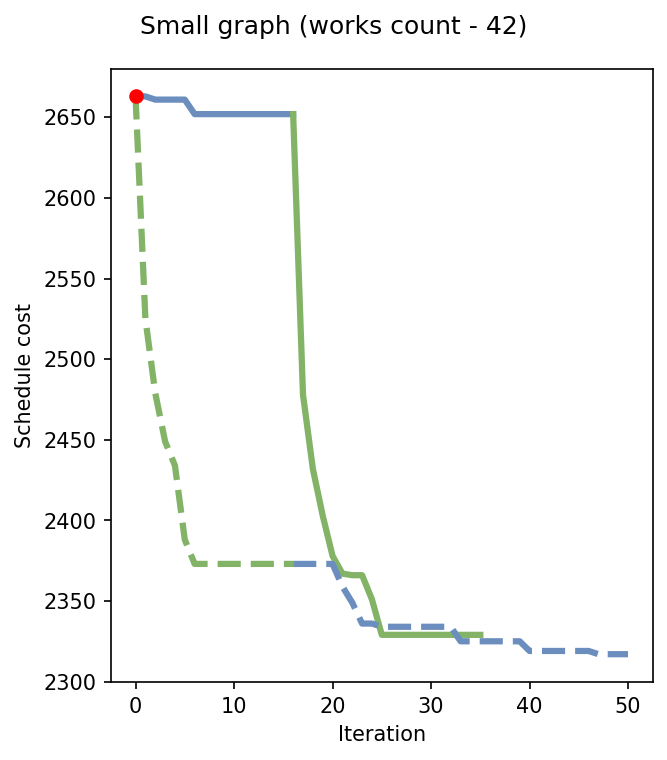

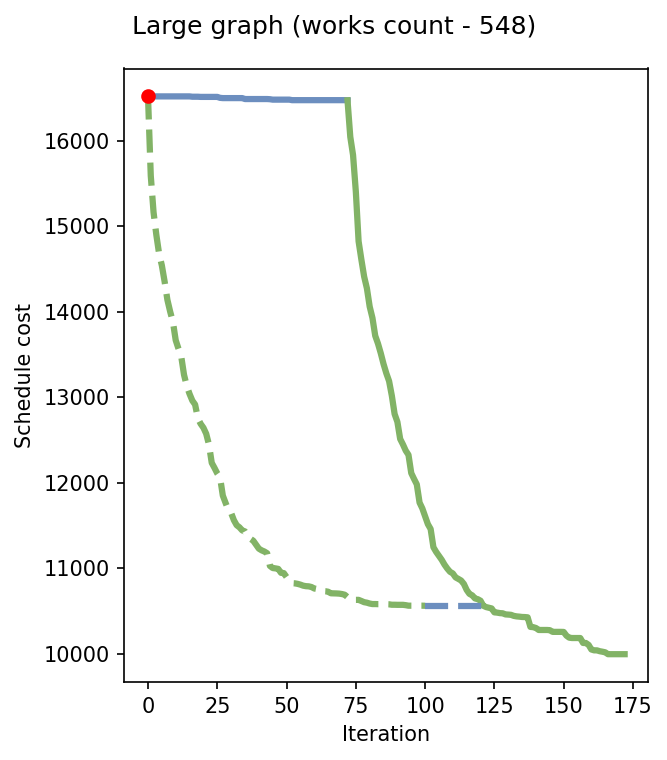

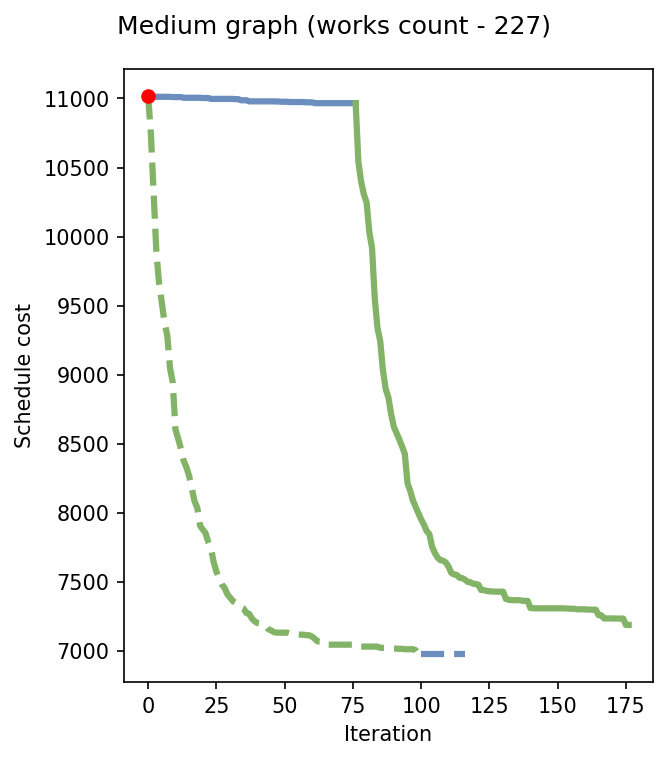

In [13]:
for fname in both_files:
    fig, ax = get_plot_from_file(f'{STORAGE}/{fname}')
    fig.savefig(f'{STORAGE}/066eng-stylized-{fname.split(".")[0]}.png')

# Bar chart

In [3]:
def bars(data: list):
    data.sort(key=lambda x: x['wg_name'])
    barWidth = 0.25
    fig, ax = plt.subplots(figsize =(12, 8))

    # set height of bar
    gen = [d['res-ord']['res'][0][0][0] for d in data]
    tabu = [d['res-ord']['ord'][-1][0][0] for d in data]
    print(gen)
    # Set position of bar on X axis
    br1 = np.arange(len(gen))
    br2 = [x + barWidth for x in br1]

    # Make the plot
    ax.bar(br1, gen, color ='#FFE6CC', edgecolor='#D79B00',  width = barWidth, label ='Genetic algorithm')
    ax.bar(br2, tabu, color ='#D5E8D4', edgecolor='#82B366', width = barWidth, label ='Tabu search')

    def gname(wg):
        return wg
        match wg:
            case 'large':
                return 'большой'
            case 'medium':
                return 'средний'
            case _:
                return 'малый'
    # Adding Xticks
    ax.set_ylabel('Schedule cost', fontsize = 14)
    ax.set_xticks([r + barWidth for r in range(len(gen))],
            [f"{gname(d['wg_name']).capitalize()} graph" for d in data], fontsize=13)

    ax.legend(fontsize=13)
    fig.suptitle('Schedule cost comparison for Tabu search and Genetic algorithm', fontsize=15)
    return fig, ax

[16516.0, 11015.0, 2663.0]


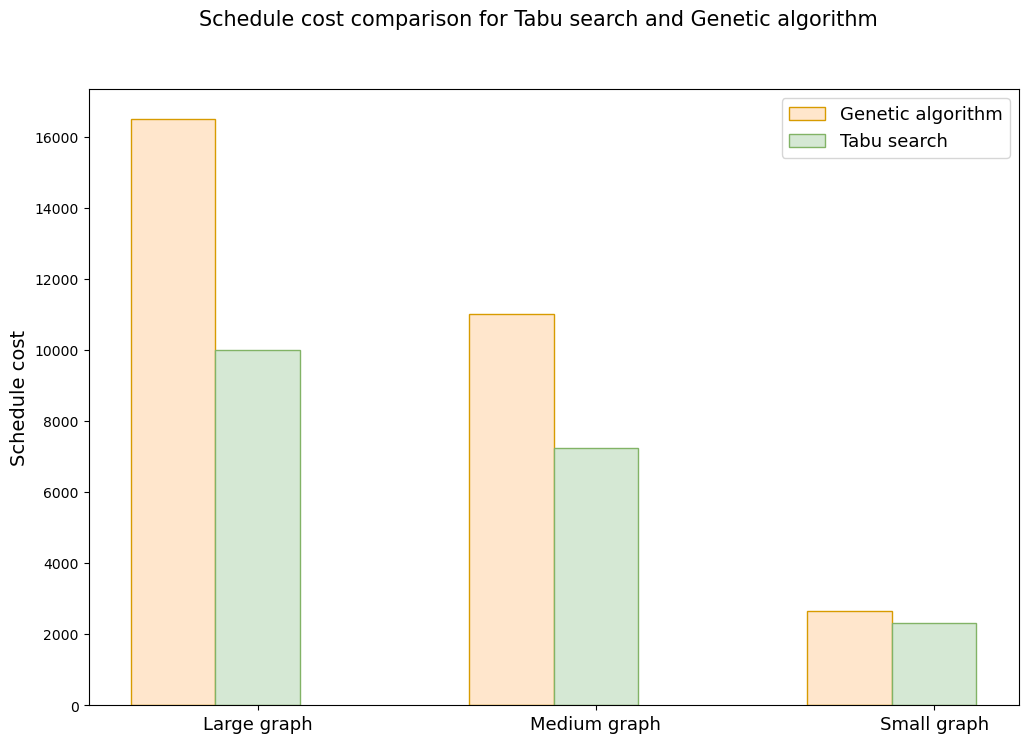

In [15]:
data_ = []
for fname in both_files:
    with open(f'{STORAGE}/{fname}', 'rb') as pkl:
        data_.append(pickle.load(pkl))
fig, ax = bars(data_)
fig.savefig(f'{STORAGE}/bar.png')

# Histogram

In [7]:
def get_init_and_result(d, first='res'):
    second = 'ord' if first == 'res' else 'res'
    init = d[first][0][0][0] # first -> history -> initial_step -> value
    result = d[second][1][-1][0] # second -> hall_of_fame -> best -> value
    return init, result

def get_eng_wg_name(name):
    match name:
        case 'real-0':
            return 'Real tiny'
        case 'real-1':
            return 'Real small'
        case int() as name:
            return f'{name}-works graph'
        case _:
            return f'{name.capitalize()} graph'

def get_hist_df(d_list):
    def improvement_percent(init, result):
        return (1 - result / init) * 100

    data_ = [(works, get_eng_wg_name(works), improvement_percent(init, result), init, result, t[-1]-t[0]) for works, t, init, result in
              ((d['works'], d['t'][1:],  *get_init_and_result(d)) for d in d_list)]

    return pd.DataFrame.from_records(data_, columns=['works', 'name', 'Improvement %', 'init', 'result', 'time'])

def get_histplot(d_list):
    df = get_hist_df(d_list)
    fig, ax = plt.subplots()
    sns.histplot(df, x='improvement', hue='name', ax=ax, bins=5, common_bins=False, kde=True)
    return fig, ax

def get_boxplot(d_list, ax):
    df = get_hist_df(d_list)
    df = df[df['works'] > 45]
    sns.boxplot(df.sort_values('works'), x='works', y='time', ax=ax, palette='muted')

In [8]:
def histplot(folder, filter=''):
    files = get_f_names(folder)
    fig, ax = get_histplot([unpickle(os.path.join(folder, f)) for f in files if filter in f])
    fig.show()

def boxplot(files):
    fig, ax = get_boxplot([unpickle(f) for f in files])
    fig.show()

/var/folders/vm/967brcmx47939tw3277dy8mm0000gn/T/ipykernel_81831/875955905.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


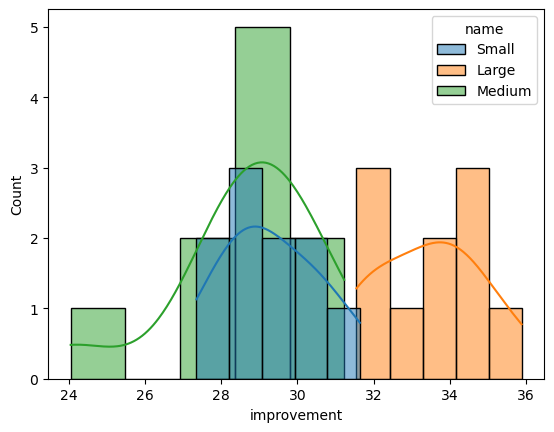

In [64]:
histplot('results')

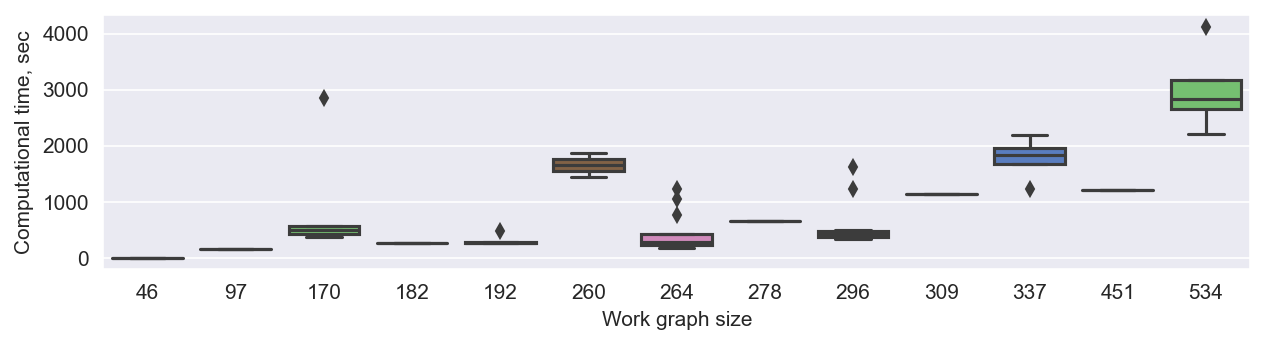

In [14]:
folders = ['results', 'results/230417', 'results/230419', 'results/230330']
files = list([os.path.join(f, file) for f in folders for file in get_f_names(f) if 'real' not in file])
dpi = 150
fig, ax = plt.subplots(figsize=(1280 / dpi, 720 / 2 / dpi), dpi=dpi)
get_boxplot([unpickle(f) for f in files], ax)
ax.set_xlabel('Work graph size')
ax.set_ylabel('Computational time, sec')
plt.tight_layout()
fig.savefig('results/boxplot.png')

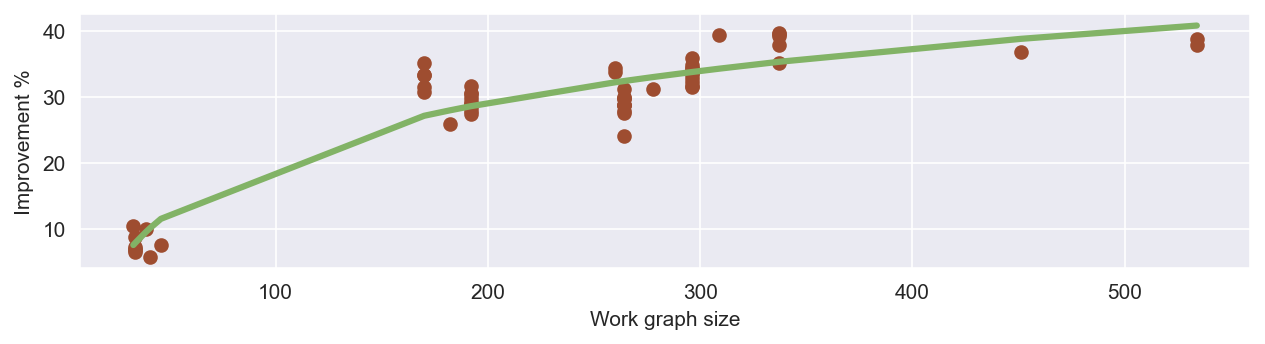

In [9]:
folders = ['results', 'results/230417', 'results/230419', 'results/230330']
files = list([os.path.join(f, file) for f in folders for file in get_f_names(f, prefix='r_o') if 'real' not in file])
improvement_df = get_hist_df([unpickle(f) for f in files]).sort_values('works')#.groupby('works').agg({'works': 'first', 'Improvement %': 'mean'})
dpi = 150
fig, ax = plt.subplots(figsize=(1280 / dpi, 720 / 2 / dpi), dpi=dpi)
ax.plot(improvement_df['works'], improvement_df['Improvement %'], 'o', color='#9e4d30')
a = np.polyfit(np.log(improvement_df['works']), improvement_df['Improvement %'], 1)
y = a[0] * np.log(improvement_df['works']) + a[1]
ax.plot(improvement_df['works'], y, '#82B366', lw = 3)
ax.set_xlabel('Work graph size')
ax.set_ylabel('Improvement %')
plt.tight_layout()
fig.savefig('results/lineplot.png')

In [105]:
display(improvement_df)

,works,name,Improvement %,init,result
52,33,33-works graph,10.461957,2208.0,1977.0
1,34,34-works graph,7.290234,1454.0,1348.0
4,34,34-works graph,6.808803,1454.0,1355.0
5,34,34-works graph,6.946355,1454.0,1353.0
9,34,34-works graph,6.533700,1454.0,1359.0
14,34,34-works graph,8.734525,1454.0,1327.0
49,39,39-works graph,9.937888,1610.0,1450.0
48,41,41-works graph,5.792466,2814.0,2651.0
51,46,46-works graph,7.535264,2694.0,2491.0
0,170,170-works graph,31.510846,7883.0,5399.0


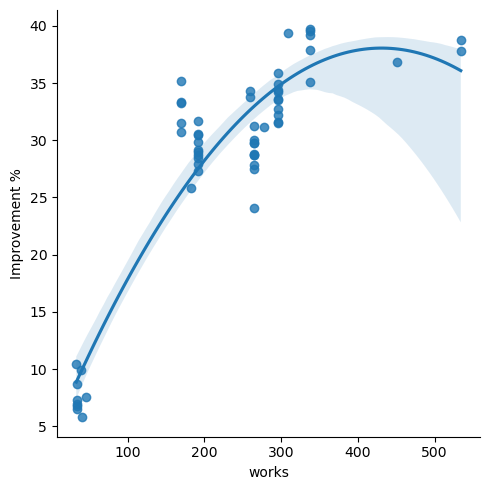

In [128]:
sns.lmplot(x='works',y='Improvement %', data=improvement_df, order=2)